<a href="https://colab.research.google.com/github/mqifjjfwiot/boardgame/blob/main/board_game_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install -r './requirements.txt'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import os
from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import shutil
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split

폴더 구조는 다음과 같습니다.
- data_dir : 학습 파일 폴더(보드게임 별로 구분)
- model_save_path : 모델 pt 파일 저장 경로
- test_dir : 테스트 데이터 폴더 경로(보드게임 구분 없이 바로 파일)
- save_dir : 결과 csv파일로 저장할 경로

In [ ]:
data_dir= "/content/drive/MyDrive/Colab Notebooks/보드게임/train"
# 테스트 데이터셋 폴더 경로를 지정해주세요.
model_save_path = "/content/drive/MyDrive/Colab Notebooks/보드게임/model"
test_dir = "/content/drive/MyDrive/Colab Notebooks/보드게임/test"
save_dir = "/content/drive/MyDrive/Colab Notebooks/보드게임"

In [ ]:
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

In [ ]:
data_list = os.listdir(data_dir)
data_list

['포인트샐러드', '병사들의귀환', '웰컴백투더던전']

라벨링
 - 0 : 포인트샐러드
 - 1 : 병사들의귀환
 - 2 : 웰컴백투더던전

In [ ]:
# 파일 이름 변경
for idx1, board_game in enumerate(data_list):
    for card_folder in os.listdir(os.path.join(data_dir, board_game)):
        for idx2, card in enumerate(os.listdir(os.path.join(data_dir, board_game, card_folder))):
            card_origin_path = os.path.join(data_dir, board_game, card_folder, card)
            card_new_path = os.path.join(data_dir, board_game, card_folder, f"{board_game}_{card_folder}_{idx2}_label{idx1}.jpg")
            os.rename(card_origin_path, card_new_path)

In [ ]:
# test 데이터 셋 분리
# 0번, 7번 사진 test set으로 이용
for idx1, board_game in enumerate(data_list):
    for card_folder in os.listdir(os.path.join(data_dir, board_game)):
        for idx2, card in enumerate(os.listdir(os.path.join(data_dir, board_game, card_folder))):
            board_name, card_type, number, label = card.split("_")
            card_origin_path = os.path.join(data_dir, board_game, card_folder, card)
            if number == "0" or number == "7":
                card_new_path = os.path.join(test_dir, card)
                if not os.path.exists(card_new_path):
                  shutil.move(card_origin_path, card_new_path)


train set 판다스 데이터프레임으로 생성

In [ ]:
data_dict = {}
data_dict['name'] = []
data_dict['board_game'] = []
data_dict['card'] = []
data_dict['label'] = []
data_dict['path'] = []

In [ ]:
for idx1, board_game in enumerate(data_list):
    for card_folder in os.listdir(os.path.join(data_dir, board_game)):
        for idx2, card in enumerate(os.listdir(os.path.join(data_dir, board_game, card_folder))):
            card_path = os.path.join(data_dir, board_game, card_folder, card)
            card_names = card.split(".")

            data_dict['name'].append(card)
            data_dict['board_game'].append(board_game)
            data_dict['card'].append(card_folder)
            # data_dict['label'].append(int(card_names[-2]))
            data_dict['label'].append(idx1)
            data_dict['path'].append(card_path)
            # card_new_path = os.path.join(data_dir, board_game, card_folder, f"{board_game}_{card_folder}_{idx2}_label{idx1}.jpg")

In [ ]:
train_df = pd.DataFrame(data_dict, columns = ['name', 'board_game', 'card', 'label', 'path'])

In [ ]:
train_df.tail()

,name,board_game,card,label,path
1038,웰컴백투더던전_황금열쇠_13_label2.jpg,웰컴백투더던전,황금열쇠,2,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
1039,웰컴백투더던전_황금열쇠_14_label2.jpg,웰컴백투더던전,황금열쇠,2,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
1040,웰컴백투더던전_황금열쇠_15_label2.jpg,웰컴백투더던전,황금열쇠,2,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
1041,웰컴백투더던전_황금열쇠_0_label2.jpg,웰컴백투더던전,황금열쇠,2,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
1042,웰컴백투더던전_황금열쇠_7_label2.jpg,웰컴백투더던전,황금열쇠,2,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...


In [ ]:
print(len(train_df))

1043


In [ ]:
train_df.isnull().sum()

name          0
board_game    0
card          0
label         0
path          0
dtype: int64

In [ ]:
train = train_df.copy()

In [ ]:
# 파일 이름, 보드 게임명, 카드 종류데이터는 학습에서 활용하지 않으므로 제외
train = train.drop(columns=["name", "board_game", "card"])

In [ ]:
train.head()

,label,path
0,0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
1,0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
2,0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
3,0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
4,0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, train, transform):
        self.x = train['path']
        self.y = train['label']
        self.transform = transform
        
    def __getitem__(self, index):
        image = Image.open(self.x.iloc[index])
        label = self.y.iloc[index]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label)
        
    def __len__(self):
        return len(self.x)

In [ ]:
transform = transforms.Compose([
    # transforms.CenterCrop((320, 256)),
    transforms.Resize((256, 256), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


train, valid set 분리 (비율 4 : 1)

In [ ]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['label'], random_state=42)

In [ ]:
train_set.head()

,label,path
947,2,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
230,0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
530,1,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
383,1,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
173,0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...


In [ ]:
valid_set.head()

,label,path
71,0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
48,0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
323,1,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
713,2,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...
591,1,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...


In [ ]:
train_set.shape, valid_set.shape

((834, 2), (209, 2))

In [ ]:
# torchvision의 resnet18 pretrained 모델 사용
model = torchvision.models.resnet18(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import math
OUTPUT = 3
model.fc = torch.nn.Linear(in_features=512, out_features=OUTPUT, bias=True)
torch.nn.init.xavier_uniform_(model.fc.weight)
stdv = 1 / math.sqrt(model.fc.weight.size(1))
model.fc.bias.data.uniform_(-stdv, stdv)

model.fc.weight.shape[0]

3

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
BATCH_SIZE = 16

In [ ]:
train_dataset = CustomDataset(train_set, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

valid_dataset = CustomDataset(valid_set, transform)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

In [ ]:
model.to(device)

LEARNING_RATE = (1e-3)
EPOCH = 5

loss_func = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
#scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
# scheduler.step() epoch 다 돌고 마지막에 넣어주면 댐

dataloaders = {
    'Train' : train_loader,
    'Valid' : valid_loader
}

In [ ]:
from tqdm import tqdm
torch.backends.cudnn.enabled = False

In [ ]:
for epoch in range(EPOCH):
    for phase in ['Train', 'Valid']:
        running_loss = 0
        running_acc = 0
        
        if phase == 'Train':
            model.train()
        elif phase == 'Valid':
            model.eval()
            
        for i, (image, label) in enumerate(tqdm(dataloaders[phase])):
            image = image.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'Train'):
                logits = model(image)
                _, preds = torch.max(logits, 1)
                loss = loss_func(logits, label)
                
                if phase == 'Train':
                    loss.backward()
                    optimizer.step()
            running_loss += loss.item() * image.size(0)
            running_acc += torch.sum(preds == label.data)
            
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)
        
        torch.save(model.state_dict(), os.path.join(model_save_path, f"{epoch+1}.pt")) # epoch별 pt파일 저장

        print(f"[Epoch {epoch+1} | {phase:5}] 평균 loss: {epoch_loss:.3f}, 평균 acc: {epoch_acc:.3f}")
    
    scheduler.step()

print('끝')

100%|██████████| 53/53 [09:39<00:00, 10.93s/it]


[Epoch 1 | Train] 평균 loss: 0.865, 평균 acc: 0.809


100%|██████████| 14/14 [01:33<00:00,  6.69s/it]


[Epoch 1 | Valid] 평균 loss: 0.756, 평균 acc: 0.746


100%|██████████| 53/53 [08:35<00:00,  9.73s/it]


[Epoch 2 | Train] 평균 loss: 0.255, 평균 acc: 0.914


100%|██████████| 14/14 [01:31<00:00,  6.53s/it]


[Epoch 2 | Valid] 평균 loss: 0.090, 평균 acc: 0.971


100%|██████████| 53/53 [08:36<00:00,  9.74s/it]


[Epoch 3 | Train] 평균 loss: 0.066, 평균 acc: 0.974


100%|██████████| 14/14 [01:31<00:00,  6.52s/it]


[Epoch 3 | Valid] 평균 loss: 0.023, 평균 acc: 0.990


100%|██████████| 53/53 [08:33<00:00,  9.69s/it]


[Epoch 4 | Train] 평균 loss: 0.041, 평균 acc: 0.987


100%|██████████| 14/14 [01:32<00:00,  6.58s/it]


[Epoch 4 | Valid] 평균 loss: 0.017, 평균 acc: 0.995


100%|██████████| 53/53 [08:35<00:00,  9.73s/it]


[Epoch 5 | Train] 평균 loss: 0.024, 평균 acc: 0.998


100%|██████████| 14/14 [01:35<00:00,  6.86s/it]


[Epoch 5 | Valid] 평균 loss: 0.028, 평균 acc: 0.995
끝


valid set 예측 + 틀린 예측이 있었으면 어떤 경우인지 살펴보기

In [ ]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X, y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred, 1)
            
            result.append([valid_set.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
        result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
        return result

In [ ]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle = False)
check_eval_df = check_eval(valid_set, valid_testing_dataloader, model, device)
check_eval_df

,path,pred,target
0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,0,0
1,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,0,0
2,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,1
3,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,2,2
4,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,1
...,...,...,...
204,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,1
205,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,1
206,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,0,0
207,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,0,0


In [ ]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,pred,target
0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,2,0


In [ ]:
wrong_df.shape

(1, 3)

In [ ]:
def draw(df):
    plt.figure(figsize = (15, 30))
    row = 1 # 출력할 row 수
    show_num_in_a_row = 2 # 한 줄에 출력할 이미지 수
    for i in range(show_num_in_a_row):
        plt.subplot(row+1, show_num_in_a_row//row, i+1)
        plt.imshow(Image.open(df['path'][i]))
        pathes = df['path'][i].split('_')

        result = 'pred:' + str(df['pred'][i]) + ' ans: ' + str(df['target'][i])
        plt.title(result)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

KeyError: ignored

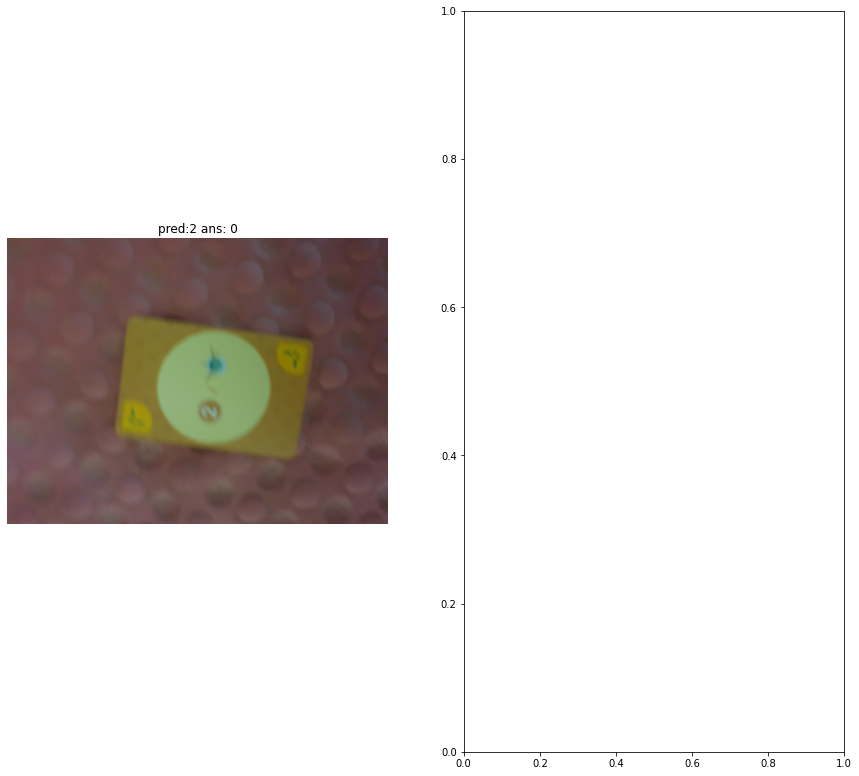

In [ ]:
draw(wrong_df)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
f1_score(check_eval_df['target'], check_eval_df['pred'], average = 'macro')

# Test set 예측
- 이미 저장된 pt파일을 활용할 경우 학습 없이 현재 코드부터 실행

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
from pathlib import Path
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm

In [ ]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
model_save_path = "/content/drive/MyDrive/Colab Notebooks/보드게임/model"
test_dir = "/content/drive/MyDrive/Colab Notebooks/보드게임/test"
save_dir = "/content/drive/MyDrive/Colab Notebooks/보드게임"
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(save_dir, exist_ok=True)

In [ ]:
class TestDataset(Dataset):
    def __init__(self, test, transform):
        self.x = test['path']
        self.y = test['label']
        self.transform = transform
        
    def __getitem__(self, index):
        image = Image.open(self.x.iloc[index])
        label = self.y.iloc[index]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label)
        
    def __len__(self):
        return len(self.x)

- make_test_with_label : 정답 라벨과 예측 라벨을 같이 보고 싶은 경우
- make_test_without_label : 정답 라벨을 모르는 경우

In [ ]:
def make_test_with_label(test_dir, predict_col=True):
  test_dict = {}
  test_dict['path'] = []
  test_dict['label'] = []
  columns = ["path", "label"]
  if predict_col:
    test_dict['predict'] = []
    columns.append("predict")

  for idx, card in enumerate(os.listdir(test_dir)):
    card_names = card.split(".")
    if card_names[-1] != 'jpg':
      continue
    label = card_names[-2].split("label")[-1]
    card_path = os.path.join(test_dir, card)
    test_dict['path'].append(card_path)
    test_dict['label'].append(int(label))
    if predict_col:
      test_dict['predict'].append("")

  return test_dict, columns

In [ ]:
def make_test_without_label(test_dir, predict_col=True):
  test_dict = {}
  test_dict['path'] = []
  columns = ["path"]
  if predict_col:
    test_dict['predict'] = []
    columns.append("predict")

  for idx, card in enumerate(os.listdir(test_dir)):
    card_names = card.split(".")
    if card_names[-1] != 'jpg':
      continue
    card_path = os.path.join(test_dir, card)
    test_dict['path'].append(card_path)
    if predict_col:
      test_dict['predict'].append("")

  return test_dict, columns


In [ ]:
test_dict, test_columns = make_test_with_label(test_dir)
print(len(test_dict["path"]), len(test_dict["label"]))

195 195


In [ ]:
test_df = pd.DataFrame(test_dict, columns=test_columns)

In [ ]:
test_df.head()

,path,label,predict
0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,
1,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,
2,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,
3,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,
4,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,


In [ ]:
submission = test_df.copy()
transform = transforms.Compose([
    # transforms.CenterCrop((320, 256)),
    transforms.Resize((256, 256), Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [ ]:
BATCH_SIZE = 16

In [ ]:
dataset = TestDataset(test_df, transform)

loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size=BATCH_SIZE, 
    num_workers=1
)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
# 학습한 모델 파일을 사용하려면 pt파일을 load (주석 해제하고 사용)
# 학습한 모델 파일을 사용하지 않으려면 load하지 않음(코드 모두 주석처리해야함)
# OUTPUT = 3
# model = torchvision.models.resnet18()
# model.fc = torch.nn.Linear(in_features=512, out_features=OUTPUT, bias=True)
# model.load_state_dict(torch.load(os.path.join(model_save_path, f"5.pt")))

In [ ]:
model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장
all_predictions = []
for (images, label) in tqdm(loader):
    with torch.no_grad():
        # pred = model.forward(images.to(device))
        # _, y_pred = torch.max(pred, 1)
        # all_predictions.extend(y_pred.cpu().numpy())
        
        images = images.to(device)
        pred = model(images)
        pred = pred.argmax(dim=-1)
        all_predictions.extend(pred.cpu().numpy())

100%|██████████| 13/13 [01:25<00:00,  6.55s/it]


In [ ]:
print(len(all_predictions))

195


In [ ]:
submission['predict'] = all_predictions

# 예측 결과 파일 저장
submission.to_csv(os.path.join(save_dir, 'submission.csv'), index=False, encoding="utf-8-sig")
print('test inference is done!')

test inference is done!


In [ ]:
submission.head()

,path,label,predict
0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,1
1,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,1
2,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,1
3,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,1
4,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,1,1


In [ ]:
def draw(df):
    plt.figure(figsize = (15, 30))
    row = 1 # 출력할 row 수
    show_num_in_a_row = 1 # 한 줄에 출력할 이미지 수
    for i in range(show_num_in_a_row):
        plt.subplot(row+1, show_num_in_a_row//row, i+1)
        plt.imshow(Image.open(df['path'][i]))
        pathes = df['path'][i].split('_')

        result = 'pred:' + str(df['predict'][i]) + ' ans: ' + str(df['label'][i])
        plt.title(result)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
wrong_df = submission[submission['predict'] != submission['label']]
wrong_df = wrong_df.reset_index(drop=True)
wrong_df

,path,label,predict
0,/content/drive/MyDrive/Colab Notebooks/보드게ᄋ...,0,2


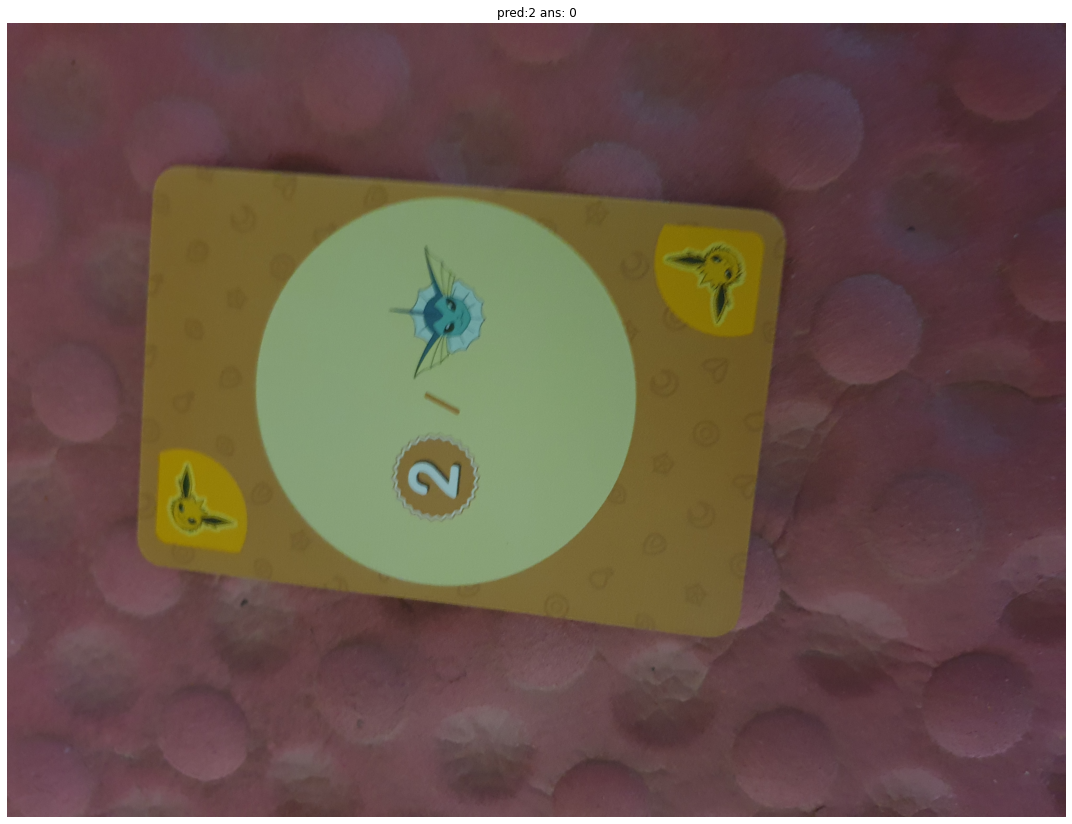

In [ ]:
draw(wrong_df)